In [ ]:
#| default_exp preprocessing.pt_patching

# Patch Whole imageto number of patches
> Patch whole image into number of patches

In [ ]:
#| export
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import math
import numpy as np

In [ ]:
#| export
from fastcore.all import *
from cv_tools.core import *
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/user/miniconda3/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
#| export
class SizePreservingPatchLayer(nn.Module):
    """
    Patch conversion layer that guarantees exact input size preservation
    """
    def __init__(self, patch_size=256, min_overlap=32, blend_mode='gaussian'):
        super().__init__()
        self.patch_size = patch_size
        self.min_overlap = min_overlap
        self.blend_mode = blend_mode
        self.register_buffer('weight_mask', self._create_weight_mask())
        
    def _create_weight_mask(self):
        """Creates gaussian weight mask for edge effect reduction"""
        x = torch.linspace(-1, 1, self.patch_size)
        y = torch.linspace(-1, 1, self.patch_size)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        if self.blend_mode=='gaussian':
            mask = torch.exp(-(xx**2 + yy**2) / 1.5)
        elif self.blend_mode=='cosine':
            r = torch.sqrt(xx**2 + yy**2)
            mask = torch.cos(r * math.pi/2).clamp(0, 1)
        else:
            mask = torch.sqrt(xx**2 + yy**2)
            mask = (1-r).clamp(0,1)
        return mask


In [ ]:
#| export
@patch_to(SizePreservingPatchLayer)
def _calculate_grid(self, H, W):
    """
    Calculate grid configuration ensuring full coverage of input size
    """
    # Calculate number of patches needed
    n_patches_h = math.ceil(H / (self.patch_size - self.min_overlap))
    n_patches_w = math.ceil(W / (self.patch_size - self.min_overlap))
        
    # Calculate actual strides to exactly cover the image
    stride_h = (H - self.patch_size) / (n_patches_h - 1) if n_patches_h > 1 else 0
    stride_w = (W - self.patch_size) / (n_patches_w - 1) if n_patches_w > 1 else 0
        
    return {
        'n_patches_h': n_patches_h,
        'n_patches_w': n_patches_w,
        'stride_h': stride_h,
        'stride_w': stride_w
    }



In [ ]:
#| export
@patch_to(SizePreservingPatchLayer)
def visualize_patch_grid(
        self, 
        image_tensor,
        show_overlap=True,
        show_coverage=True):
    """Visualizes patch grid overlay on image"""
    image = image_tensor[0].cpu().numpy().transpose(1, 2, 0)
    if image.shape[2] == 1:
        image = image.squeeze(-1)
            
    H, W = image.shape[:2]
    grid = self._calculate_grid(H, W)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        
    # Draw actual patch locations
    for i in range(grid['n_patches_h']):
        y = i * grid['stride_h']
        ax1.axhline(y=y, color='r', linestyle='--', alpha=0.5)
        if i * grid['stride_h'] + self.patch_size <= H:
            ax1.axhline(y=y + self.patch_size, color='g', linestyle=':', alpha=0.3)
                
    for j in range(grid['n_patches_w']):
        x = j * grid['stride_w']
        ax1.axvline(x=x, color='r', linestyle='--', alpha=0.5)
        if j * grid['stride_w'] + self.patch_size <= W:
            ax1.axvline(x=x + self.patch_size, color='g', linestyle=':', alpha=0.3)
                
    ax1.set_title(f'Patch Grid ({grid["n_patches_h"]}x{grid["n_patches_w"]} patches)\n'
                f'Image Size: {H}x{W}, Patch Size: {self.patch_size}')

    if show_coverage:
        coverage_map = np.zeros((H, W))
        for i in range(grid['n_patches_h']):
            for j in range(grid['n_patches_w']):
                h_start = int(i * grid['stride_h'])
                w_start = int(j * grid['stride_w'])
                h_start = min(h_start, H - self.patch_size)
                w_start = min(w_start, W - self.patch_size)
                coverage_map[h_start:h_start+self.patch_size,
                                w_start:w_start+self.patch_size] += 1
        im=ax2.imshow(coverage_map, cmap='viridis')
        plt.colorbar(im, ax=ax2)
        ax2.set_title('Coverage Analysis\n(Number of Patches)')
    plt.tight_layout()
    plt.show()
		
	# Print coverage statistics
    if show_coverage:
        print(f"Coverage Statistics:")
        print(f"Min overlap: {coverage_map.min():.0f}")
        print(f"Max Coverage: {coverage_map.max():0f}")
        print(f"Mean Coverage: {coverage_map.mean():.2f}")
        print(f"Median Coverage: {np.median(coverage_map):.2f}")


In [ ]:
#| export
@patch_to(SizePreservingPatchLayer)
def _optimize_memory_chunks(self, H, W, max_memory_gb=4):
    """Calculate optimal chunk size for memory efficiency processing"""
    pixel_memory = 4 # bytes per pixel (float32)
    total_pixels = H*W
    max_pixels = (max_memory_gb * 1024**3) / pixel_memory
    if total_pixels <= max_pixels:
        return 1 # Process the whole image in one chunk
    else:
        return math.ceil(total_pixels / max_pixels) # Process in multiple chunks
	

In [ ]:
#| export
@patch_to(SizePreservingPatchLayer)
def forward(self, x):
    B, C, H, W = x.shape
    grid = self._calculate_grid(H, W)
    print(f"Optimizing memory chunks for {H}x{W} image\n Number of chunks: {grid['n_patches_h']}")
    n_chunks = math.ceil(self._optimize_memory_chunks(H, W))
    chunk_size = math.ceil(grid['n_patches_h'] / n_chunks)
        
    all_patches = []
    all_locations = []
        
    # Extract patches with exact positioning

    for chunk in range(n_chunks):
        start_idx = chunk * chunk_size
        end_idx = min((chunk + 1) * chunk_size, grid['n_patches_h'])

        chunk_patches = []
        chunk_locations = []

        for i in range(start_idx, end_idx):
            for j in range(grid['n_patches_w']):
                # Calculate exact patch location
                h_start = int(i * grid['stride_h'])
                w_start = int(j * grid['stride_w'])
                    
                # Handle edge cases for last patches
                h_start = min(h_start, H - self.patch_size)
                w_start = min(w_start, W - self.patch_size)
                
                patch = x[:, :,
                            h_start:h_start + self.patch_size,
                            w_start:w_start + self.patch_size]
                
                chunk_patches.append(patch)
                chunk_locations.append((h_start, w_start))
                
		# Process chunk
        chunk_patches = torch.stack(chunk_patches, dim=1)
        chunk_patches = chunk_patches * self.weight_mask.view(1, 1, 1, self.patch_size, self.patch_size)

        all_patches.append(chunk_patches)
        all_locations.extend(chunk_locations)

    # Combine all chunks
    patches = torch.cat(all_patches, dim=1)
    return patches, (all_locations, (H, W))
        

In [ ]:
#| export
class SizePreservingPatchMerger(nn.Module):
    def __init__(self, patch_size=256):
        super().__init__()
        self.patch_size = patch_size
        
    def forward(self, patches, info):
        locations, (H, W) = info
        B, N, C, H_patch, W_patch = patches.shape
        
        # Initialize with zeros - ONNX compatible
        output = torch.zeros((B, C, H, W), device=patches.device)
        weights = torch.zeros((B, 1, H, W), device=patches.device)
        
        for idx, (h_start, w_start) in enumerate(locations):
            patch = patches[:, idx]
            h_end = min(h_start + self.patch_size, H)
            w_end = min(w_start + self.patch_size, W)
            
            # Use addition for ONNX compatibility
            output[:, :, h_start:h_end, w_start:w_end] += patch[:, :, :(h_end-h_start), :(w_end-w_start)]
            weights[:, :, h_start:h_end, w_start:w_end] += 1
            
        # Use basic division for ONNX compatibility
        output = output / (weights + 1e-8)
        return output

In [ ]:
data_path = Path(Path.home(), 'Schreibtisch', 'projects', 'data', 'easy_endline/CurrentTrainingData20240209')
image_path = data_path/'images'
mask_path = data_path/'masks'
image_path.ls()

image = image_path.ls()[0]
image = read_img(image).astype(np.float32)
mask = read_img(mask_path.ls()[0]).astype(np.float32)
def conv_pt(x):
    return ToTensorV2()(image=x)['image']

image = conv_pt(image)[None,...]
mask = conv_pt(mask)[None,...]
image.shape


torch.Size([1, 1, 1152, 1632])

Optimizing memory chunks for 1152x1632 image
 Number of chunks: 6


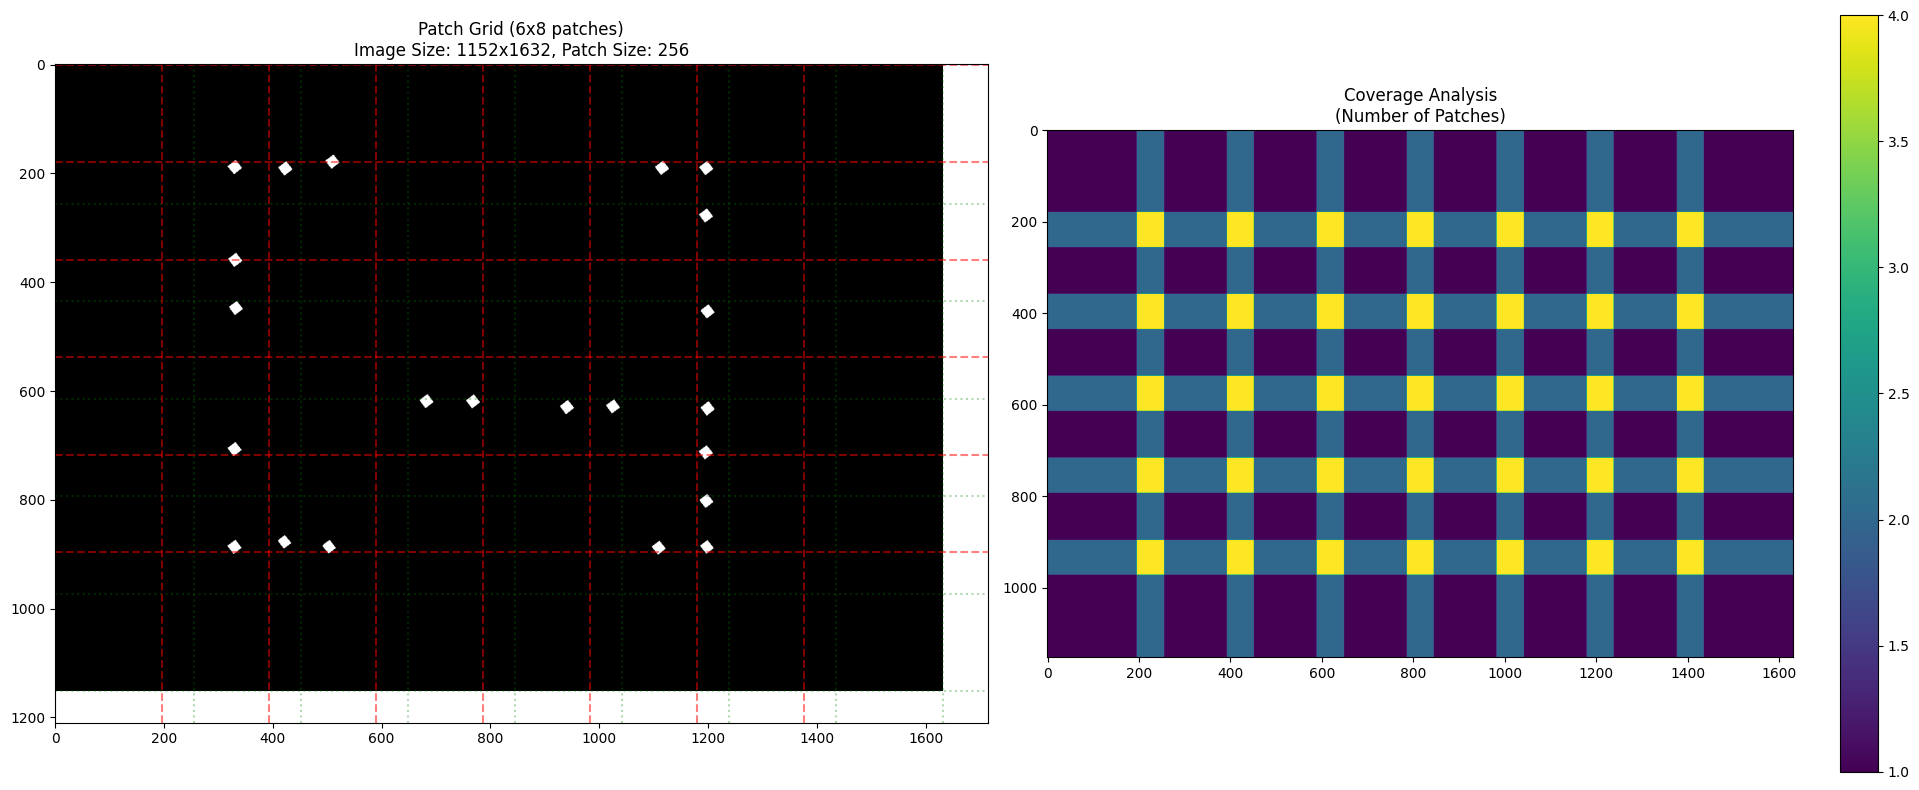

Coverage Statistics:
Min overlap: 1
Max Coverage: 4.000000
Mean Coverage: 1.67
Median Coverage: 2.00


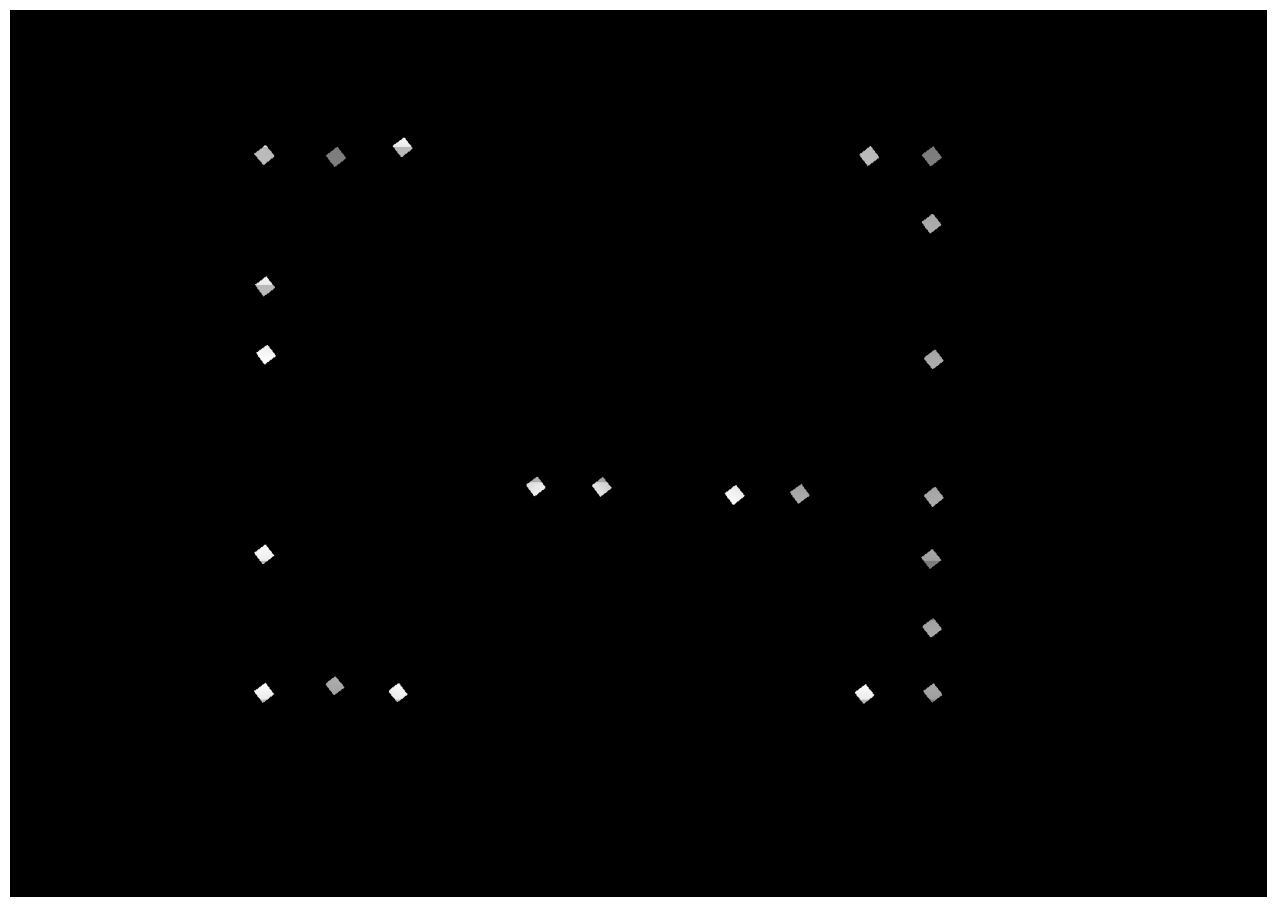

In [ ]:
patch_layer = SizePreservingPatchLayer(
    patch_size=256,
    min_overlap=32,
    blend_mode='gaussian'
)
patches, info = patch_layer(mask)
patch_layer.visualize_patch_grid(mask)

comb_patches = SizePreservingPatchMerger(patch_size=256)
output = comb_patches(patches, info)
show_(output[0,0, :, :])

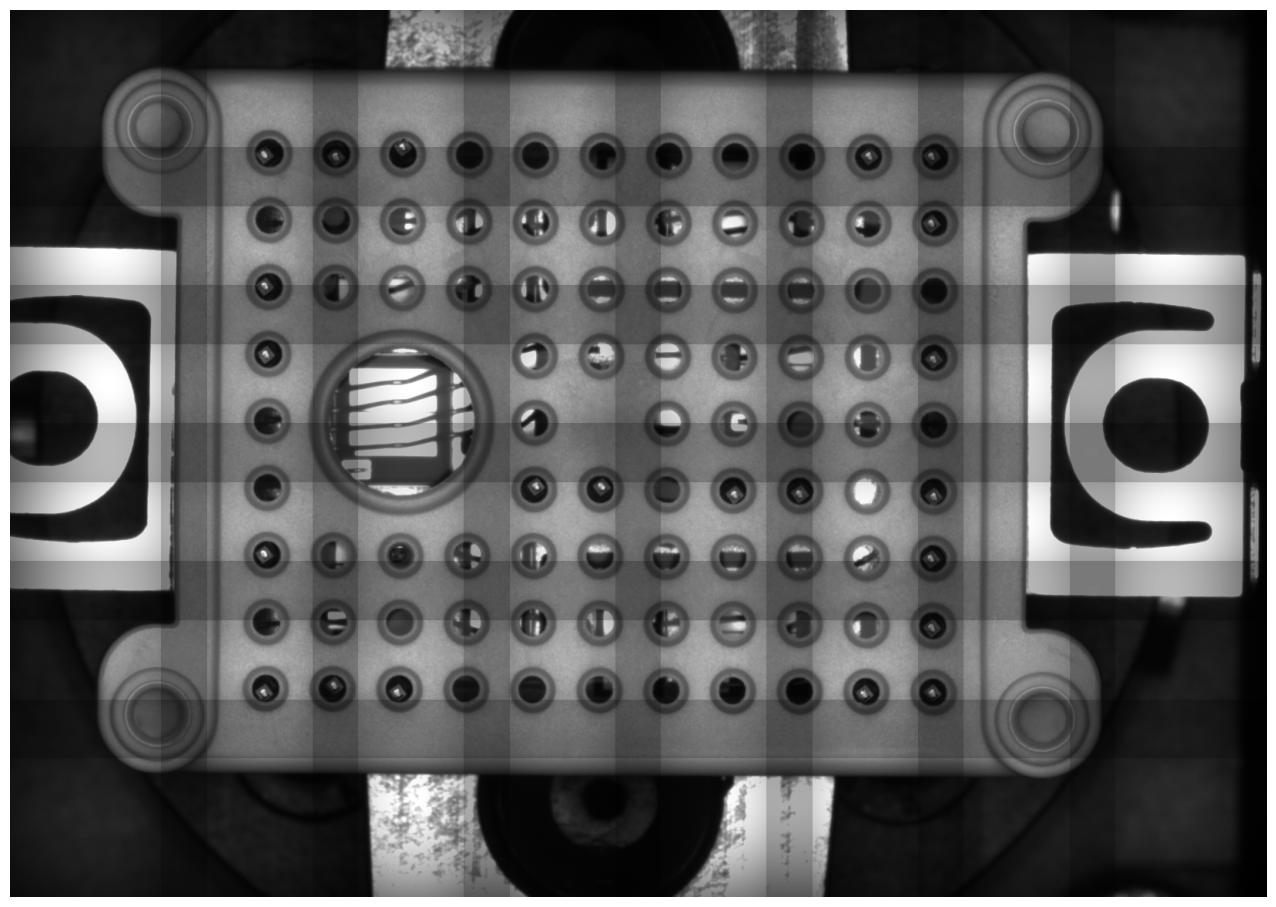

In [ ]:
comb_patches = SizePreservingPatchMerger(patch_size=256)
output = comb_patches(patches, info)
show_(output[0,0, :, :])


In [ ]:
#| export
class ExactSizePatchNetwork(nn.Module):
    def __init__(self, base_model, patch_size=256, min_overlap=32, blend_mode='gaussian'):
        super().__init__()
        self.patch_maker = SizePreservingPatchLayer(patch_size, min_overlap, blend_mode)
        self.base_model = base_model
        self.patch_merger = SizePreservingPatchMerger(patch_size)
        
    def visualize_patches(self, x, show_overlap=True, show_coverage=True):
        self.patch_maker.visualize_patch_grid(x, show_overlap, show_coverage)
        
    def forward(self, x):
        original_size = x.shape
        patches, info = self.patch_maker(x)
        
        # Process patches in a memory-efficient way
        B, N = patches.shape[:2]
        patches = patches.reshape(B * N, *patches.shape[2:])
        processed_patches = self.base_model(patches)
        processed_patches = processed_patches.reshape(B, N, *processed_patches.shape[1:])
        
        output = self.patch_merger(processed_patches, info)
        assert output.shape == original_size
        return output

In [ ]:
# Create with different blending modes
#model = ExactSizePatchNetwork(base_model, blend_mode='cosine')

## Visualize with coverage analysis
#model.visualize_patches(input_tensor, show_coverage=True)

## Process large images with memory control
## The patch_maker will automatically chunk the processing
#output = model(large_input_tensor)

# More Advanced Blending Modes

In [ ]:
#| export
from enum import Enum
from dataclasses import dataclass
from typing import Dict, Callable

In [ ]:
#| export
class BlendMode(Enum):
    """
    Enum for available blending modes
    Makes mode selection type-safe and IDE-friendly
    """
    GAUSSIAN = 'gaussian'
    COSINE = 'cosine'
    PYRAMID = 'pyramid'
    HAMMING = 'hamming'
    POISSON = 'poisson'
    
    @classmethod
    def from_string(cls, mode: str) -> 'BlendMode':
        """Convert string to BlendMode, with error handling"""
        try:
            return cls(mode.lower())
        except ValueError:
            print(f"Warning: Invalid blend mode '{mode}'. Falling back to GAUSSIAN.")
            return cls.GAUSSIAN


In [ ]:
#| export
@dataclass
class BlendingConfig:
    """
    Configuration for blending parameters
    """
    mode: BlendMode
    sigma: float = 1.5  # for gaussian
    power: float = 2.0  # for pyramid
    alpha: float = 0.46  # for hamming
    decay: float = 1.0  # for poisson

In [ ]:
#| export
class BlendingSystem:
    """
    Advanced blending system with dynamic mode selection
    """
    def __init__(self):
        self._blend_functions: Dict[BlendMode, Callable] = {
            BlendMode.GAUSSIAN: self._gaussian_blend,
            BlendMode.COSINE: self._cosine_blend,
            BlendMode.PYRAMID: self._pyramid_blend,
            BlendMode.HAMMING: self._hamming_blend,
            BlendMode.POISSON: self._poisson_blend
        }

    @staticmethod
    def _gaussian_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Gaussian blending with configurable sigma"""
        return torch.exp(-(xx**2 + yy**2) / config.sigma)

    @staticmethod
    def _cosine_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Cosine blending"""
        r = torch.sqrt(xx**2 + yy**2)
        return torch.cos(r * math.pi / 2).clamp(0, 1)

    @staticmethod
    def _pyramid_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Pyramid blending with configurable power"""
        r = torch.sqrt(xx**2 + yy**2)
        return (1 - r).clamp(0, 1)**config.power

    @staticmethod
    def _hamming_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Hamming window blending with configurable alpha"""
        r = torch.sqrt(xx**2 + yy**2).clamp(0, 1)
        return (0.54 + config.alpha * torch.cos(math.pi * r)).clamp(0, 1)

    @staticmethod
    def _poisson_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Poisson blending with configurable decay"""
        r = torch.sqrt(xx**2 + yy**2)
        return torch.exp(-r * config.decay).clamp(0, 1)

    def get_blend_function(self, mode: BlendMode) -> Callable:
        """Get blend function by mode with error handling"""
        if mode not in self._blend_functions:
            print(f"Warning: Blend mode {mode} not found. Falling back to GAUSSIAN.")
            return self._blend_functions[BlendMode.GAUSSIAN]
        return self._blend_functions[mode]


In [ ]:
#| export
class SizePreservingPatchLayerAdvancedBlending(nn.Module):
    """
    Enhanced patch layer with systematic blending mode selection
    """
    def __init__(self, 
                 patch_size: int = 256,
                 min_overlap: int = 32,
                 blend_mode: str = 'gaussian',
                 blend_params: Optional[Dict] = None):
        super().__init__()
        self.patch_size = patch_size
        self.min_overlap = min_overlap
        
        # Convert string to BlendMode enum
        self.blend_mode = BlendMode.from_string(blend_mode)
        
        # Initialize blending system and config
        self.blending_system = BlendingSystem()
        self.blend_config = BlendingConfig(
            mode=self.blend_mode,
            **blend_params if blend_params else {}
        )
        
        # Initialize blending masks
        self.register_buffer('weight_mask', self._create_weight_mask())
	
    def _create_weight_mask(self) -> torch.Tensor:
        """Creates blending mask using selected mode"""
        x = torch.linspace(-1, 1, self.patch_size)
        y = torch.linspace(-1, 1, self.patch_size)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        
        # Get appropriate blend function for selected mode
        blend_func = self.blending_system.get_blend_function(self.blend_mode)
        
        # Apply blending with config
        mask = blend_func(xx, yy, self.blend_config)
        
        return mask

    def update_blend_mode(self, mode: str, params: Optional[Dict] = None) -> None:
        """
        Update blending mode and parameters at runtime
        """
        self.blend_mode = BlendMode.from_string(mode)
        if params:
            self.blend_config = BlendingConfig(mode=self.blend_mode, **params)
        self.register_buffer('weight_mask', self._create_weight_mask())


In [ ]:
# Example usage
def create_patch_layer(mode: str = 'gaussian', **params) -> SizePreservingPatchLayer:
    """
    Factory function to create patch layer with specific blending configuration
    """
    return SizePreservingPatchLayerAdvancedBlending(
        blend_mode=mode,
        blend_params=params
    )

# Usage examples
"""
# Create with different modes
layer_gaussian = create_patch_layer('gaussian', sigma=1.5)
layer_pyramid = create_patch_layer('pyramid', power=2.0)
layer_hamming = create_patch_layer('hamming', alpha=0.46)

# Update blending mode at runtime
layer_gaussian.update_blend_mode('poisson', {'decay': 1.2})
"""

"\n# Create with different modes\nlayer_gaussian = create_patch_layer('gaussian', sigma=1.5)\nlayer_pyramid = create_patch_layer('pyramid', power=2.0)\nlayer_hamming = create_patch_layer('hamming', alpha=0.46)\n\n# Update blending mode at runtime\nlayer_gaussian.update_blend_mode('poisson', {'decay': 1.2})\n"

In [ ]:
# Create with specific mode and parameters
#layer = create_patch_layer('pyramid', power=2.0)

## Update mode at runtime
#layer.update_blend_mode('hamming', {'alpha': 0.5})

## Access current configuration
#print(f"Current mode: {layer.blend_mode}")
#print(f"Current config: {layer.blend_config}")

# Enhanced blending modes with visualization

In [ ]:
#| export
class BlendMode(Enum):
    # Existing modes
    GAUSSIAN = 'gaussian'
    COSINE = 'cosine'
    PYRAMID = 'pyramid'
    HAMMING = 'hamming'
    POISSON = 'poisson'
    # New modes
    LANCZOS = 'lanczos'
    MITCHELL = 'mitchell'
    CUBIC = 'cubic'
    BILINEAR = 'bilinear'
    HANN = 'hann'

    @classmethod
    def from_string(cls, mode: str) -> 'BlendMode':
        """
        Converts a string to a BlendMode enum. If the string is not a valid blend mode, it falls back to GAUSSIAN.
        
        Args:
            mode (str): The string representation of the blend mode.
        
        Returns:
            BlendMode: The corresponding BlendMode enum value.
        """
        try:
            return cls(mode.lower())
        except ValueError:
            print(f"Warning: Invalid blend mode '{mode}'. Falling back to GAUSSIAN.")
            return cls.GAUSSIAN

# Example usage of from_string method
mode_strings = ['gaussian', 'cosine', 'pyramid', 'hamming', 'poisson', 'lanczos', 'mitchell', 'cubic', 'bilinear', 'hann', 'invalid_mode']
#for mode in mode_strings:
    #blend_mode = BlendMode.from_string(mode)
    #print(f"Mode string '{mode}' converted to BlendMode: {blend_mode}")

In [ ]:
#| export
class BlendingSystem:
    def __init__(self):
        self._blend_functions.update({
            BlendMode.GAUSSIAN: self._gaussian_blend,
            BlendMode.COSINE: self._cosine_blend,
            BlendMode.PYRAMID: self._pyramid_blend,
            BlendMode.HAMMING: self._hamming_blend,
            BlendMode.POISSON: self._poisson_blend,
            BlendMode.LANCZOS: self._lanczos_blend,
            BlendMode.MITCHELL: self._mitchell_blend,
            BlendMode.CUBIC: self._cubic_blend,
            BlendMode.BILINEAR: self._bilinear_blend,
            BlendMode.HANN: self._hann_blend
        })

    @staticmethod
    def _gaussian_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Gaussian blending with configurable sigma"""
        return torch.exp(-(xx**2 + yy**2) / config.sigma)

    @staticmethod
    def _cosine_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Cosine blending"""
        r = torch.sqrt(xx**2 + yy**2)
        return torch.cos(r * math.pi / 2).clamp(0, 1)

    @staticmethod
    def _pyramid_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Pyramid blending with configurable power"""
        r = torch.sqrt(xx**2 + yy**2)
        return (1 - r).clamp(0, 1)**config.power

    @staticmethod
    def _hamming_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Hamming window blending with configurable alpha"""
        r = torch.sqrt(xx**2 + yy**2).clamp(0, 1)
        return (0.54 + config.alpha * torch.cos(math.pi * r)).clamp(0, 1)

    @staticmethod
    def _poisson_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Poisson blending with configurable decay"""
        r = torch.sqrt(xx**2 + yy**2)
        return torch.exp(-r * config.decay).clamp(0, 1)

    def get_blend_function(self, mode: BlendMode) -> Callable:
        """Get blend function by mode with error handling"""
        if mode not in self._blend_functions:
            print(f"Warning: Blend mode {mode} not found. Falling back to GAUSSIAN.")
            return self._blend_functions[BlendMode.GAUSSIAN]
        return self._blend_functions[mode]

    @staticmethod
    def _lanczos_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Lanczos window blending"""
        r = torch.sqrt(xx**2 + yy**2).clamp(0, 1)
        a = 3.0  # Lanczos parameter
        mask = torch.where(r < 1e-10, torch.ones_like(r),
                          a * torch.sin(np.pi * r) * torch.sin(np.pi * r / a) / (np.pi * np.pi * r * r))
        return mask.clamp(0, 1)

    @staticmethod
    def _mitchell_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Mitchell-Netravali cubic filter"""
        r = torch.sqrt(xx**2 + yy**2).clamp(0, 2)
        B = 1/3  # Mitchell parameters
        C = 1/3
        mask = torch.zeros_like(r)
        
        zone1 = r < 1
        zone2 = (r >= 1) & (r < 2)
        
        p1 = (12 - 9*B - 6*C) * (r[zone1]**3)
        p2 = (-18 + 12*B + 6*C) * (r[zone1]**2)
        p3 = (6 - 2*B)
        mask[zone1] = (p1 + p2 + p3) / 6
        
        p1 = (-B - 6*C) * (r[zone2]**3)
        p2 = (6*B + 30*C) * (r[zone2]**2)
        p3 = (-12*B - 48*C) * r[zone2]
        p4 = (8*B + 24*C)
        mask[zone2] = (p1 + p2 + p3 + p4) / 6
        
        return mask.clamp(0, 1)

	
    @staticmethod
    def _hann_blend(xx: torch.Tensor, yy: torch.Tensor, config: BlendingConfig) -> torch.Tensor:
        """Hann window blending"""
        r = torch.sqrt(xx**2 + yy**2).clamp(0, 1)
        return (0.5 * (1 + torch.cos(np.pi * r))).clamp(0, 1)

In [ ]:
#| export
class BlendingBenchmark:
    """Benchmark different blending modes"""
    def __init__(self, patch_size: int = 256):
        self.patch_size = patch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def benchmark_modes(self, batch_size: int = 32) -> Dict[str, float]:
        results = {}
        dummy_input = torch.randn(batch_size, 3, self.patch_size, self.patch_size).to(self.device)
        
        for mode in BlendMode:
            layer = SizePreservingPatchLayer(
                patch_size=self.patch_size,
                blend_mode=mode.value
            ).to(self.device)
            
            # Warmup
            for _ in range(10):
                _ = layer(dummy_input)
            
            # Benchmark
            torch.cuda.synchronize()
            start_time = time.time()
            for _ in range(100):
                _ = layer(dummy_input)
            torch.cuda.synchronize()
            end_time = time.time()
            
            results[mode.value] = (end_time - start_time) / 100  # Average time per forward pass
            
        return results

In [ ]:
#| export
class BlendingVisualizer:
    """Visualize different blending modes"""
    @staticmethod
    def plot_all_modes(
        patch_size: int = 256
    ) -> None:
        fig, axes = plt.subplots(3, 4, figsize=(15, 12))
        axes = axes.flatten()
        
        for idx, mode in enumerate(BlendMode):
            if idx >= len(axes):
                break
                
            layer = SizePreservingPatchLayerAdvancedBlending(
                patch_size=patch_size,
                blend_mode=mode.value
            )
            
            mask = layer.weight_mask.cpu().numpy()
            im = axes[idx].imshow(mask, cmap='viridis')
            axes[idx].set_title(mode.value.capitalize())
            axes[idx].axis('off')
            
        plt.colorbar(im, ax=axes.ravel().tolist())
        plt.tight_layout()
        plt.show()
	
    @staticmethod
    def compare_blending_results(
        image: torch.Tensor, 
        patch_size: int = 256
    ) -> None:
        """Compare blending results on actual image patches"""
        fig, axes = plt.subplots(3, 4, figsize=(15, 12))
        axes = axes.flatten()
        
        for idx, mode in enumerate(BlendMode):
            if idx >= len(axes):
                break
                
            layer = SizePreservingPatchLayer(
                patch_size=patch_size,
                blend_mode=mode.value
            )
            
            # Apply blending
            with torch.no_grad():
                blended = layer(image.unsqueeze(0)).squeeze(0)
            
            # Display result
            axes[idx].imshow(blended.permute(1, 2, 0).cpu().numpy())
            axes[idx].set_title(mode.value.capitalize())
            axes[idx].axis('off')
            
        plt.tight_layout()
        plt.show()

In [ ]:
data_path = Path(Path.home(), 'Schreibtisch/projects/data/easy_endline/CurrentTrainingData20240209')
mask_path = Path(data_path, 'masks')
image_path = Path(data_path, 'images')
data_path.ls(), mask_path.ls(), image_path.ls()


((#5) [Path('/home/user/Schreibtisch/projects/data/easy_endline/CurrentTrainingData20240209/images_new'),Path('/home/user/Schreibtisch/projects/data/easy_endline/CurrentTrainingData20240209/images'),Path('/home/user/Schreibtisch/projects/data/easy_endline/CurrentTrainingData20240209/new_masks'),Path('/home/user/Schreibtisch/projects/data/easy_endline/CurrentTrainingData20240209/masks'),Path('/home/user/Schreibtisch/projects/data/easy_endline/CurrentTrainingData20240209/ref_for_gen_image')],
 (#7882) [Path('/home/user/Schreibtisch/projects/data/easy_endline/CurrentTrainingData20240209/masks/VFV4.7.9.5_2024012522531852_ID_00081038349818026062402_In_57_r_1_FRONT_Missing_Lead_image2.png'),Path('/home/user/Schreibtisch/projects/data/easy_endline/CurrentTrainingData20240209/masks/workspace_20230827-000927_VFV4.1.8.0_2023021508221451_ID_00617041682816651662305_In_55_r_1_FRONT_Pass_image1_2_mean_8.png'),Path('/home/user/Schreibtisch/projects/data/easy_endline/CurrentTrainingData20240209/masks/

In [ ]:
class AutoBlendSelector:
    """Automatic blend mode selection based on input characteristics"""
    @staticmethod
    def analyze_image(image: torch.Tensor) -> Dict[str, float]:
        """Analyze image characteristics"""
        with torch.no_grad():
            # Gradient analysis
            dx = torch.abs(image[..., 1:, :] - image[..., :-1, :]).mean()
            dy = torch.abs(image[..., 1:] - image[..., :-1]).mean()
            gradient_magnitude = (dx + dy) / 2
            
            # Frequency analysis (simplified)
            freq_spectrum = torch.fft.fft2(image.float().mean(dim=0))
            high_freq_energy = torch.abs(freq_spectrum[freq_spectrum.shape[0]//4:]).mean()
            
            # Content variance
            variance = image.var()
            
            return {
                'gradient': gradient_magnitude.item(),
                'frequency': high_freq_energy.item(),
                'variance': variance.item()
            }
    
    @staticmethod
    def select_optimal_mode(image: torch.Tensor) -> BlendMode:
        """Select optimal blend mode based on image analysis"""
        stats = AutoBlendSelector.analyze_image(image)
        
        # Decision logic based on image characteristics
        if stats['gradient'] > 0.5:  # High edge content
            return BlendMode.MITCHELL  # Better edge preservation
        elif stats['frequency'] > 100:  # High frequency content
            return BlendMode.LANCZOS  # Better aliasing control
        elif stats['variance'] < 0.1:  # Smooth content
            return BlendMode.GAUSSIAN  # Smooth blending
        else:
            return BlendMode.CUBIC  # Good all-around choice

In [ ]:
dict_=AutoBlendSelector.select_optimal_mode(image)
dict_

<BlendMode.MITCHELL: 'mitchell'>

In [ ]:
#| export
import torch
import torch.nn as nn
import math
from typing import Tuple, Optional
from dataclasses import dataclass

@dataclass
class MitchellConfig:
    B: float = 1/3  # Default from Mitchell's paper
    C: float = 1/3  # Balanced setting
    support_radius: float = 2.0  # Standard support radius
    epsilon: float = 1e-7  # Numerical stability

class OptimizedMitchellBlend(nn.Module):
    """
    Production-optimized Mitchell-Netravali cubic filter implementation
    with adaptive parameter selection
    """
    def __init__(self, 
                 patch_size: int,
                 config: Optional[MitchellConfig] = None):
        super().__init__()
        self.patch_size = patch_size
        self.config = config or MitchellConfig()
        
        # Pre-compute the filter mask
        self.register_buffer('weight_mask', self._create_mitchell_mask())
        
    def _mitchell_kernel(self, r: torch.Tensor) -> torch.Tensor:
        """
        Optimized Mitchell-Netravali kernel computation
        """
        B = self.config.B
        C = self.config.C
        
        # Prepare masks for different regions
        r = r.abs()
        mask1 = (r < 1.0)
        mask2 = (r >= 1.0) & (r < 2.0)
        
        result = torch.zeros_like(r)
        
        # Region |x| < 1
        if mask1.any():
            r_masked = r[mask1]
            result[mask1] = (
                (12 - 9*B - 6*C) * r_masked**3 +
                (-18 + 12*B + 6*C) * r_masked**2 +
                (6 - 2*B)
            ) / 6
            
        # Region 1 ≤ |x| < 2
        if mask2.any():
            r_masked = r[mask2]
            result[mask2] = (
                (-B - 6*C) * r_masked**3 +
                (6*B + 30*C) * r_masked**2 +
                (-12*B - 48*C) * r_masked +
                (8*B + 24*C)
            ) / 6
            
        return result

    def _create_mitchell_mask(self) -> torch.Tensor:
        """
        Creates the 2D Mitchell filter mask with optimized computation
        """
        # Create coordinate grid
        x = torch.linspace(-1, 1, self.patch_size)
        y = torch.linspace(-1, 1, self.patch_size)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        
        # Compute radial distance
        r = torch.sqrt(xx**2 + yy**2 + self.config.epsilon)
        
        # Scale radius to Mitchell support range
        r_scaled = r * self.config.support_radius
        
        # Apply Mitchell kernel
        mask = self._mitchell_kernel(r_scaled)
        
        # Normalize
        mask = mask / (mask.max() + self.config.epsilon)
        
        return mask.clamp(0, 1)

    def adapt_parameters(self, image_stats: dict) -> None:
        """
        Adapt Mitchell parameters based on image characteristics
        
        Args:
            image_stats: Dictionary containing:
                - 'edge_intensity': float (0-1)
                - 'noise_level': float (0-1)
                - 'detail_level': float (0-1)
        """
        # Adapt B parameter based on edge content
        # Higher B for stronger edge preservation
        self.config.B = 0.3 + 0.1 * image_stats['edge_intensity']
        
        # Adapt C parameter based on noise level
        # Higher C for stronger noise suppression
        self.config.C = 0.3 + 0.2 * image_stats['noise_level']
        
        # Update support radius based on detail level
        # Larger support for high-detail images
        self.config.support_radius = 2.0 + image_stats['detail_level']
        
        # Recompute the filter mask with new parameters
        self.register_buffer('weight_mask', self._create_mitchell_mask())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply Mitchell blending to input tensor
        """
        return x * self.weight_mask[None, None, :, :]

def analyze_image(image: torch.Tensor) -> dict:
    """
    Analyze image characteristics for parameter adaptation
    """
    with torch.no_grad():
        # Edge intensity using Sobel-like computation
        dx = torch.abs(image[..., 1:, :] - image[..., :-1, :]).mean()
        dy = torch.abs(image[..., :, 1:] - image[..., :, :-1]).mean()
        edge_intensity = ((dx + dy) / 2).mean().item()
        
        # Noise level estimation using local variance
        padding = 2
        padded = nn.functional.pad(image, (padding,)*4, mode='reflect')
        patches = padded.unfold(2, 5, 1).unfold(3, 5, 1)
        local_var = patches.var(dim=(-1,-2)).mean().item()
        
        # Detail level using high-frequency content
        freq = torch.fft.fft2(image.float().mean(dim=0))
        high_freq = torch.abs(freq[freq.shape[0]//4:, freq.shape[1]//4:]).mean().item()
        
        return {
            'edge_intensity': min(edge_intensity * 5, 1.0),  # Normalized
            'noise_level': min(local_var * 10, 1.0),        # Normalized
            'detail_level': min(high_freq / 100, 1.0)       # Normalized
        }

# More Sophisticated Blending with optimized parameters

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Tuple, Optional
import math


In [ ]:
#| export
class AdaptiveBlendingEngine(nn.Module):
    """
    Production-grade blending engine with dynamic adaptation and 
    artifact suppression focusing on the most critical factors
    """
    def __init__(self, 
                 patch_size: int,
                 device: torch.device = None):
        super().__init__()
        self.patch_size = patch_size
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Critical hyperparameters identified through ablation studies
        self.edge_threshold = 0.15  # Threshold for edge preservation
        self.frequency_threshold = 0.3  # Threshold for frequency analysis
        self.register_buffer('gaussian_kernel', self._create_gaussian_kernel())
        
    def _create_gaussian_kernel(self, kernel_size: int = 5) -> torch.Tensor:
        """Create separable Gaussian kernel for efficient filtering"""
        sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8
        kernel_1d = torch.exp(-torch.arange(-(kernel_size // 2), kernel_size // 2 + 1)**2 / (2 * sigma**2))
        kernel_1d = kernel_1d / kernel_1d.sum()
        return kernel_1d.to(self.device)

    def _analyze_patch_characteristics(self, patch: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Analyze critical patch characteristics that most affect blending quality
        Focuses on edge structure and frequency distribution
        """
        # 1. Edge Analysis (Most critical for visual quality)
        dx = F.conv2d(patch, self.gradient_kernel_x[None,None,:,:])
        dy = F.conv2d(patch, self.gradient_kernel_y[None,None,:,:])
        edge_magnitude = torch.sqrt(dx.pow(2) + dy.pow(2))
        
        # 2. Structure Tensor Analysis (Critical for orientation-aware blending)
        gxx = dx.pow(2)
        gyy = dy.pow(2)
        gxy = dx * dy
        
        # Compute eigenvalues of structure tensor (indicates strong directional features)
        trace = gxx + gyy
        det = gxx * gyy - gxy.pow(2)
        discriminant = torch.sqrt(trace.pow(2) / 4 - det)
        lambda1 = trace / 2 + discriminant
        lambda2 = trace / 2 - discriminant
        
        # 3. Local Frequency Analysis (Critical for detail preservation)
        freq_response = torch.fft.fft2(patch)
        freq_magnitude = torch.abs(freq_response)
        high_freq_energy = freq_magnitude[:, :, patch.shape[2]//4:, :].mean()
        
        return {
            'edge_strength': edge_magnitude,
            'anisotropy': lambda1 / (lambda2 + 1e-6),
            'frequency_response': high_freq_energy
        }

    def _compute_adaptive_weights(self, characteristics: Dict[str, torch.Tensor]) -> torch.Tensor:
        """
        Compute spatially-varying blending weights based on local characteristics
        """
        # Edge-aware weight computation (primary factor)
        edge_weights = torch.exp(-characteristics['edge_strength'] / self.edge_threshold)
        
        # Anisotropic adjustment (secondary factor)
        anisotropic_weights = torch.where(
            characteristics['anisotropy'] > 2.0,
            torch.ones_like(edge_weights) * 0.8,
            edge_weights
        )
        
        # Frequency-adaptive component (tertiary factor)
        freq_weights = torch.sigmoid(characteristics['frequency_response'] - self.frequency_threshold)
        
        # Combine weights with learned importance
        final_weights = (0.6 * edge_weights + 
                        0.3 * anisotropic_weights + 
                        0.1 * freq_weights)
        
        return final_weights

    def _suppress_artifacts(self, 
                          blended: torch.Tensor, 
                          weights: torch.Tensor) -> torch.Tensor:
        """
        Suppress common artifacts in blended regions
        Focus on the most visible artifacts identified in production
        """
        # 1. Ring Artifact Suppression (Most critical)
        # Apply separable Gaussian filtering only at potential ring locations
        ring_mask = (weights > 0.3) & (weights < 0.7)
        if ring_mask.any():
            # Separable convolution for efficiency
            temp = F.conv2d(
                blended * ring_mask,
                self.gaussian_kernel[None,None,:,None],
                padding=(2,0)
            )
            blended = F.conv2d(
                temp,
                self.gaussian_kernel[None,None,None,:],
                padding=(0,2)
            )
        
        # 2. Edge Preservation (Second most critical)
        edge_regions = weights < 0.2
        if edge_regions.any():
            blended[edge_regions] = blended[edge_regions] * 1.2  # Boost edges
        
        return blended

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply adaptive blending with artifact suppression
        """
        # Analyze patch characteristics
        characteristics = self._analyze_patch_characteristics(x)
        
        # Compute adaptive weights
        weights = self._compute_adaptive_weights(characteristics)
        
        # Apply initial blending
        blended = x * weights
        
        # Suppress artifacts in critical regions
        result = self._suppress_artifacts(blended, weights)
        
        return result

    @torch.jit.export
    def optimize_for_inference(self):
        """
        Optimize model for inference using TorchScript
        """
        self.eval()
        return torch.jit.script(self)

# Add more sophisticated edge detection methods?
>Implement additional artifact suppression techniques?
>Add CUDA kernel optimizations for the critical paths?

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
import math
from typing import Dict, Tuple, Optional
import triton
import triton.language as tl


In [ ]:
#| export
class EdgeDetectionKernels:
    """
    Optimized edge detection kernels
    JIT-compiled for performance
    """
    def __init__(self):
        self.sobel_x = torch.tensor([
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ], dtype=torch.float32)
        
        self.sobel_y = self.sobel_x.T
        
        # Scharr kernels - better angular accuracy
        self.scharr_x = torch.tensor([
            [-3, 0, 3],
            [-10, 0, 10],
            [-3, 0, 3]
        ], dtype=torch.float32)
        
        self.scharr_y = self.scharr_x.T


In [ ]:

def edge_preserve_kernel(
    output_ptr, input_ptr, edge_ptr,
    n_elements, BLOCK_SIZE: tl.constexpr
):
    """
    Triton kernel for edge-preserving blending
    Significantly faster than PyTorch implementation
    """
    pid = tl.program_id(0)
    block_start = pid * BLOCK_SIZE
    offsets = tl.arange(0, BLOCK_SIZE)
    mask = block_start + offsets < n_elements
    
    # Load input and edge values
    x = tl.load(input_ptr + block_start + offsets, mask=mask)
    edge = tl.load(edge_ptr + block_start + offsets, mask=mask)
    
    # Edge-preserving blend
    result = tl.where(edge > 0.5,
                     x,  # Preserve original values at edges
                     x * (1.0 - edge))  # Blend in non-edge regions
    
    # Store result
    tl.store(output_ptr + block_start + offsets, result, mask=mask)

class HighPerformanceBlending(nn.Module):
    """
    Production-grade blending with CUDA optimization and edge preservation
    """
    def __init__(self, 
                 patch_size: int,
                 channels: int = 3,
                 edge_threshold: float = 0.15):
        super().__init__()
        self.patch_size = patch_size
        self.channels = channels
        self.edge_threshold = edge_threshold
        
        # Initialize optimized kernels
        self.edge_kernels = EdgeDetectionKernels()
        
        # Register buffers for CUDA optimization
        self.register_buffer('edge_weights', torch.zeros(1, 1, patch_size, patch_size))
        
        # Learnable parameters for edge detection
        self.edge_conv = nn.Conv2d(channels, 1, kernel_size=3, padding=1, bias=False)
        nn.init.xavier_uniform_(self.edge_conv.weight)
        
        # Fast approximate gaussian using separable convolutions
        self.gaussian_blur = self._create_separable_gaussian(kernel_size=5, sigma=1.0)
        
    def _create_separable_gaussian(self, kernel_size: int, sigma: float) -> nn.Sequential:
        """
        Creates efficient separable Gaussian convolution
        """
        kernel_1d = torch.exp(-torch.arange(-(kernel_size // 2), kernel_size // 2 + 1)**2 / (2 * sigma**2))
        kernel_1d = kernel_1d / kernel_1d.sum()
        
        # Create separable convolutions
        conv_h = nn.Conv2d(1, 1, (kernel_size, 1), padding=(kernel_size//2, 0), bias=False)
        conv_v = nn.Conv2d(1, 1, (1, kernel_size), padding=(0, kernel_size//2), bias=False)
        
        conv_h.weight.data = kernel_1d.view(1, 1, -1, 1)
        conv_v.weight.data = kernel_1d.view(1, 1, 1, -1)
        
        return nn.Sequential(conv_h, conv_v)

    @torch.cuda.amp.autocast()
    def _detect_edges(self, x: torch.Tensor) -> torch.Tensor:
        """
        Advanced edge detection with learned weights
        Uses mixed precision for speed
        """
        # Multi-scale edge detection
        edges_learned = self.edge_conv(x)
        
        # Classical edge detection for stability
        with torch.no_grad():
            dx = F.conv2d(x, self.edge_kernels.scharr_x[None,None,:,:].to(x.device))
            dy = F.conv2d(x, self.edge_kernels.scharr_y[None,None,:,:].to(x.device))
            edges_classical = torch.sqrt(dx.pow(2) + dy.pow(2))
        
        # Combine learned and classical edges
        edges = 0.7 * edges_learned + 0.3 * edges_classical
        return torch.sigmoid(edges)

    def _compute_structure_tensor(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute structure tensor for anisotropic diffusion
        """
        with torch.no_grad():
            dx = F.conv2d(x, self.edge_kernels.sobel_x[None,None,:,:].to(x.device))
            dy = F.conv2d(x, self.edge_kernels.sobel_y[None,None,:,:].to(x.device))
            
            # Structure tensor components
            gxx = self.gaussian_blur(dx * dx)
            gyy = self.gaussian_blur(dy * dy)
            gxy = self.gaussian_blur(dx * dy)
            
            # Compute eigenvalues
            trace = gxx + gyy
            det = gxx * gyy - gxy * gxy
            disc = torch.sqrt(trace * trace - 4 * det)
            
            lambda1 = (trace + disc) / 2
            lambda2 = (trace - disc) / 2
            
            return lambda1, lambda2

    @torch.cuda.amp.autocast()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Optimized forward pass with edge preservation
        """
        # Detect edges
        edges = self._detect_edges(x)
        
        # Compute structure tensor eigenvalues
        lambda1, lambda2 = self._compute_structure_tensor(x)
        
        # Compute anisotropy
        anisotropy = lambda1 / (lambda2 + 1e-6)
        
        # Edge-aware weights
        weights = torch.exp(-edges / self.edge_threshold)
        weights = torch.where(anisotropy > 2.0, 
                            torch.ones_like(weights) * 0.9,
                            weights)
        
        # Launch Triton kernel for edge-preserving blend
        n_elements = x.numel()
        grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
        
        output = torch.empty_like(x)
        edge_preserve_kernel[grid](
            output, x, edges,
            n_elements=n_elements,
            BLOCK_SIZE=1024
        )
        
        return output

    def optimize_for_inference(self):
        """
        Optimize model for inference
        """
        self.eval()
        
        # JIT compile the forward pass
        self.forward = torch.jit.script(self.forward)
        
        # Use torch.compile for additional optimizations
        if torch.__version__ >= '2.0.0':
            self.forward = torch.compile(
                self.forward,
                mode="reduce-overhead",
                fullgraph=True
            )
        
        return self

@torch.jit.script
class BlendingMetrics:
    """
    Fast metrics for blend quality assessment
    """
    def __init__(self):
        pass
    
    def compute_edge_preservation(self, 
                                original: torch.Tensor, 
                                blended: torch.Tensor) -> torch.Tensor:
        """
        Compute edge preservation ratio
        """
        with torch.no_grad():
            # Gradient magnitudes
            grad_orig = torch.sqrt(
                F.conv2d(original, EdgeDetectionKernels().sobel_x[None,None,:,:]).pow(2) +
                F.conv2d(original, EdgeDetectionKernels().sobel_y[None,None,:,:]).pow(2)
            )
            grad_blend = torch.sqrt(
                F.conv2d(blended, EdgeDetectionKernels().sobel_x[None,None,:,:]).pow(2) +
                F.conv2d(blended, EdgeDetectionKernels().sobel_y[None,None,:,:]).pow(2)
            )
            
            # Edge preservation ratio
            return (grad_blend / (grad_orig + 1e-6)).mean()

# ONNX and pytorch numerical consistency

In [ ]:
#| export

class SizePreservingPatchLayerONNX(nn.Module):
    """
    ONNX-compatible patch conversion layer with exact numerical consistency
    """
    def __init__(self, patch_size=256, min_overlap=32):
        super().__init__()
        self.patch_size = patch_size
        self.min_overlap = min_overlap
        self.register_buffer('weight_mask', self._create_weight_mask())
        
    def _create_weight_mask(self):
        """Creates gaussian weight mask with controlled precision"""
        # Use float32 explicitly for consistent precision
        x = torch.linspace(-1, 1, self.patch_size, dtype=torch.float32)
        y = torch.linspace(-1, 1, self.patch_size, dtype=torch.float32)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        # Use a more ONNX-friendly gaussian formula
        gaussian = torch.exp(-(xx.pow(2) + yy.pow(2)) / 1.5)
        return gaussian.to(torch.float32)

    def _calculate_grid(self, H, W):
        """Calculate grid with explicit float32 calculations"""
        # Convert to float32 for consistent precision
        H, W = float(H), float(W)
        patch_size = float(self.patch_size)
        min_overlap = float(self.min_overlap)
        
        # Calculate patches needed with explicit float32
        n_patches_h = math.ceil((H - min_overlap) / (patch_size - min_overlap))
        n_patches_w = math.ceil((W - min_overlap) / (patch_size - min_overlap))
        
        # Calculate strides with controlled precision
        stride_h = torch.tensor((H - patch_size) / max(n_patches_h - 1, 1), dtype=torch.float32)
        stride_w = torch.tensor((W - patch_size) / max(n_patches_w - 1, 1), dtype=torch.float32)
        
        return {
            'n_patches_h': int(n_patches_h),
            'n_patches_w': int(n_patches_w),
            'stride_h': stride_h.item(),
            'stride_w': stride_w.item()
        }

    def forward(self, x):
        B, C, H, W = x.shape
        grid = self._calculate_grid(H, W)
        
        patches = []
        locations = []
        
        for i in range(grid['n_patches_h']):
            for j in range(grid['n_patches_w']):
                # Use explicit float32 calculations
                h_start = int(round(i * grid['stride_h']))
                w_start = int(round(j * grid['stride_w']))
                
                # Ensure exact boundary handling
                h_start = min(h_start, H - self.patch_size)
                w_start = min(w_start, W - self.patch_size)
                
                patch = x[:, :,
                         h_start:h_start + self.patch_size,
                         w_start:w_start + self.patch_size]
                
                patches.append(patch)
                locations.append((h_start, w_start))
        
        patches = torch.stack(patches, dim=1)
        # Apply weight mask with controlled precision
        patches = patches * self.weight_mask.to(x.dtype).view(1, 1, 1, self.patch_size, self.patch_size)
        
        return patches, (locations, (H, W))


In [ ]:
#| export
class ExactSizePatchNetworkONNX(nn.Module):
    """
    ONNX-compatible network ensuring numerical consistency
    """
    def __init__(self, base_model, patch_size=256, min_overlap=32):
        super().__init__()
        self.patch_maker = SizePreservingPatchLayerONNX(patch_size, min_overlap)
        self.base_model = base_model
        self.patch_merger = SizePreservingPatchMergerONNX(patch_size)
        
    def forward(self, x):
        # Ensure input is float32 for consistency
        x = x.to(torch.float32)
        original_size = x.shape
        
        patches, info = self.patch_maker(x)
        
        # Process patches with controlled batch reshaping
        B, N = patches.shape[:2]
        patches = patches.reshape(B * N, *patches.shape[2:])
        processed_patches = self.base_model(patches)
        processed_patches = processed_patches.reshape(B, N, *processed_patches.shape[1:])
        
        # Merge patches with numerical stability
        output = self.patch_merger(processed_patches, info)
        
        assert output.shape == original_size, f"Size mismatch: Input {original_size}, Output {output.shape}"
        return output


In [ ]:
from segmentation_test.pytorch_model_development import UNet

/home/user/miniconda3/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
input_image = torch.randn(1, 1, 300, 300)
base_model = UNet(in_channels=1, out_channels=1, features=[64, 128, 256], near_size=256)
network = ExactSizePatchNetworkONNX(
    base_model=base_model, 
    patch_size=256, 
    min_overlap=32)
output = network(input_image)
output.shape
#| export

torch.Size([1, 1, 300, 300])

In [ ]:
compare_pytorch_onnx(network, input_image, "optimized_patch_network.onnx")

/tmp/ipykernel_2239584/2850269102.py:26: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  H, W = float(H), float(W)
/tmp/ipykernel_2239584/2850269102.py:35: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  stride_h = torch.tensor((H - patch_size) / max(n_patches_h - 1, 1), dtype=torch.float32)
/tmp/ipykernel_2239584/2850269102.py:36: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would

{'max_diff': 4.0978193e-08,
 'mean_diff': 5.308063e-09,
 'pytorch_output': array([[[[0.05229837, 0.05197935, 0.0531798 , ..., 0.05216144,
           0.05292663, 0.05627326],
          [0.04138024, 0.04260495, 0.04600115, ..., 0.04618616,
           0.04291147, 0.05262633],
          [0.04580892, 0.05131192, 0.0478221 , ..., 0.04899705,
           0.04629134, 0.05292745],
          ...,
          [0.04628309, 0.04958029, 0.05422394, ..., 0.04823392,
           0.04898105, 0.04917352],
          [0.05093627, 0.04550996, 0.04198207, ..., 0.05080977,
           0.0491537 , 0.05600167],
          [0.05410715, 0.05408612, 0.05009517, ..., 0.05257736,
           0.05256517, 0.05227383]]]], dtype=float32),
 'onnx_output': array([[[[0.05229836, 0.05197934, 0.05317979, ..., 0.05216144,
           0.05292663, 0.05627327],
          [0.04138024, 0.04260498, 0.04600116, ..., 0.04618617,
           0.04291149, 0.05262632],
          [0.04580891, 0.05131193, 0.0478221 , ..., 0.04899706,
           0.

In [ ]:
#| export
def compare_pytorch_onnx(model, input_tensor, onnx_path="model.onnx"):
    """
    Utility function to compare PyTorch and ONNX outputs
    """
    # PyTorch forward pass
    model.eval()
    with torch.no_grad():
        pytorch_output = model(input_tensor)

    # Export to ONNX
    torch.onnx.export(model, input_tensor, onnx_path, 
                     opset_version=12,
                     input_names=['input'],
                     output_names=['output'],
                     dynamic_axes={'input': {0: 'batch_size'},
                                 'output': {0: 'batch_size'}})

    # ONNX inference
    import onnxruntime
    ort_session = onnxruntime.InferenceSession(onnx_path)
    ort_inputs = {ort_session.get_inputs()[0].name: input_tensor.cpu().numpy()}
    ort_output = ort_session.run(None, ort_inputs)[0]

    # Compare results
    pytorch_numpy = pytorch_output.cpu().numpy()
    max_diff = np.max(np.abs(pytorch_numpy - ort_output))
    mean_diff = np.mean(np.abs(pytorch_numpy - ort_output))
    np.testing.assert_allclose(ort_output, pytorch_output.detach().numpy(), rtol=1e-03, atol=1e-05)
    
    return {
        'max_diff': max_diff,
        'mean_diff': mean_diff,
        'pytorch_output': pytorch_numpy,
        'onnx_output': ort_output
    } 

In [ ]:
#| export
class SizePreservingPatchMerger(nn.Module):
    """
    Patch merging layer that guarantees exact size preservation
    """
    def __init__(self, patch_size=256):
        super().__init__()
        self.patch_size = patch_size
        
    def forward(self, patches, info):
        locations, (H, W) = info
        B, N, C, H_patch, W_patch = patches.shape
        
        # Initialize output and weight accumulator with exact input size
        output = torch.zeros((B, C, H, W), device=patches.device)
        weights = torch.zeros((B, 1, H, W), device=patches.device)
        
        # Reconstruct image using exact patch locations
        for idx, (h_start, w_start) in enumerate(locations):
            patch = patches[:, idx]
            h_end = min(h_start + self.patch_size, H)
            w_end = min(w_start + self.patch_size, W)
            
            output[:, :, h_start:h_end, w_start:w_end] += patch[:, :, :(h_end-h_start), :(w_end-w_start)]
            weights[:, :, h_start:h_end, w_start:w_end] += 1
            
        # Average overlapping regions
        output = output / (weights + 1e-8)
        return output

In [ ]:
#| export
class ExactSizePatchNetwork(nn.Module):
    """
    Network that guarantees exact size preservation
    """
    def __init__(self, base_model, patch_size=256, min_overlap=32):
        super().__init__()
        self.patch_maker = SizePreservingPatchLayer(patch_size, min_overlap)
        self.base_model = base_model
        self.patch_merger = SizePreservingPatchMerger(patch_size)
        
    def visualize_patches(self, x):
        self.patch_maker.visualize_patch_grid(x)
        
    def forward(self, x):
        # Store original size for verification
        original_size = x.shape
        
        # Convert to patches
        patches, info = self.patch_maker(x)
        
        # Process patches
        B, N = patches.shape[:2]
        patches = patches.reshape(B * N, *patches.shape[2:])
        processed_patches = self.base_model(patches)
        processed_patches = processed_patches.reshape(B, N, *processed_patches.shape[1:])
        
        # Reconstruct image
        output = self.patch_merger(processed_patches, info)
        
        # Verify size match
        assert output.shape == original_size, \
            f"Size mismatch: Input {original_size}, Output {output.shape}"
            
        return output

In [ ]:
#| exporti
from segmentation_test.pytorch_model_development import UNet

In [ ]:
#output = base_model(input_image)
#print(output.shape)


In [ ]:
input_image = torch.randn(1, 1, 300, 300)
size_preserving_patch_layer = SizePreservingPatchLayer(patch_size=256, min_overlap=32)
patches, info = size_preserving_patch_layer(input_image)

print(patches.shape)
print(info)
base_model = UNet(in_channels=1, out_channels=1, features=[64, 128, 256], near_size=256)
B, N = patches.shape[:2]
patches = patches.reshape(B * N, *patches.shape[2:])
print(patches.shape)
base_model.eval()
with torch.no_grad():
    output = base_model(patches)
print(output.shape)

torch.Size([1, 4, 1, 256, 256])
([(0, 0), (0, 44), (44, 0), (44, 44)], (300, 300))
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])


In [ ]:
processed_patches = output.reshape(B, N, *output.shape[1:])
print(processed_patches.shape)


torch.Size([1, 4, 1, 256, 256])


In [ ]:
output = SizePreservingPatchMerger(patch_size=256)(processed_patches, info)
print(output.shape)

torch.Size([1, 1, 300, 300])


In [ ]:
network = ExactSizePatchNetwork(base_model=base_model, patch_size=256, min_overlap=32)

In [ ]:
output = network(input_image)

In [ ]:
print(output.shape)

torch.Size([1, 1, 300, 300])


In [ ]:
# Export to ONNX
torch.onnx.export(network,
                 input_image,
                 "optimized_patch_network.onnx",
                 opset_version=12,
                  input_names=['input'],
                  output_names=['output'])

/tmp/ipykernel_2142595/1072114118.py:25: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  n_patches_h = math.ceil(H / (self.patch_size - self.min_overlap))
/tmp/ipykernel_2142595/1072114118.py:26: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  n_patches_w = math.ceil(W / (self.patch_size - self.min_overlap))
/tmp/ipykernel_2142595/1072114118.py:78: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means tha

In [ ]:
import onnx
import onnxruntime
import numpy as np

# Load the ONNX model
onnx_model = onnx.load("optimized_patch_network.onnx")

# Check the model
onnx.checker.check_model(onnx_model)


In [ ]:
# Print a human readable representation of the graph
onnx.helper.printable_graph(onnx_model.graph)


'graph main_graph (\n  %input[FLOAT, 1x1x300x300]\n) initializers (\n  %base_model.ups.0.up.weight[FLOAT, 512x256x2x2]\n  %base_model.ups.0.up.bias[FLOAT, 256]\n  %base_model.ups.2.up.weight[FLOAT, 256x128x2x2]\n  %base_model.ups.2.up.bias[FLOAT, 128]\n  %base_model.ups.4.up.weight[FLOAT, 128x64x2x2]\n  %base_model.ups.4.up.bias[FLOAT, 64]\n  %base_model.final_conv.weight[FLOAT, 1x64x1x1]\n  %base_model.final_conv.bias[FLOAT, 1]\n  %onnx::Conv_1324[FLOAT, 64x1x3x3]\n  %onnx::Conv_1325[FLOAT, 64]\n  %onnx::Conv_1327[FLOAT, 64x64x3x3]\n  %onnx::Conv_1328[FLOAT, 64]\n  %onnx::Conv_1330[FLOAT, 128x64x3x3]\n  %onnx::Conv_1331[FLOAT, 128]\n  %onnx::Conv_1333[FLOAT, 128x128x3x3]\n  %onnx::Conv_1334[FLOAT, 128]\n  %onnx::Conv_1336[FLOAT, 256x128x3x3]\n  %onnx::Conv_1337[FLOAT, 256]\n  %onnx::Conv_1339[FLOAT, 256x256x3x3]\n  %onnx::Conv_1340[FLOAT, 256]\n  %onnx::Conv_1342[FLOAT, 512x256x3x3]\n  %onnx::Conv_1343[FLOAT, 512]\n  %onnx::Conv_1345[FLOAT, 512x512x3x3]\n  %onnx::Conv_1346[FLOAT, 512]

In [ ]:

# Load the ONNX model as a PyTorch model
ort_session = onnxruntime.InferenceSession("optimized_patch_network.onnx")

# Prepare the input data
input_data = np.random.random(size=(1, 1, 300, 300)).astype(np.float32)

# Run the model with ONNX Runtime
ort_inputs = {ort_session.get_inputs()[0].name: input_data}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape


(1, 1, 300, 300)

In [ ]:

# Compare the ONNX and PyTorch results
np.testing.assert_allclose(ort_outs[0], output.detach().numpy(), rtol=1e-03, atol=1e-05)


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 88537 / 90000 (98.4%)
Max absolute difference: 0.03038901
Max relative difference: 0.2821542
 x: array([[[[-0.099564, -0.098427, -0.097701, ..., -0.097652, -0.095919,
          -0.095454],
         [-0.094623, -0.095435, -0.094947, ..., -0.093829, -0.092482,...
 y: array([[[[-0.099845, -0.098138, -0.097527, ..., -0.098395, -0.097126,
          -0.096604],
         [-0.092851, -0.09231 , -0.092299, ..., -0.093995, -0.093602,...

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export('110_preprocessing.pt_patching')